In [2]:
import numpy as np
import tensorflow as tf
import zipfile
from urllib.request import urlretrieve 
from collections import Counter
import math
import time

In [ ]:
urlretrieve('http://mattmahoney.net/dc/text8.zip','text8.zip')

with zipfile.ZipFile('text8.zip') as zip_ref:
    zip_ref.extractall()

In [3]:
with open('text8') as f:
    text = f.read()

In [4]:
print(text[0:8])

 anarchi


In [5]:
def preprocessText(text):
    words = text.split()
    
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    counts = Counter(words)
    
    trimmedWords = [word for word in words if counts[word]>5]
    return trimmedWords

In [6]:
trimmedWords = preprocessText(text)

In [7]:
def intEncoding(words):
    counts = Counter(words)
    sortedCounts = sorted(counts, key= counts.get, reverse = True)
    wordToInt = {word:index for index,word in enumerate(sortedCounts)}
    intToWord = {index:word for index, word in enumerate(sortedCounts)}
    return wordToInt,intToWord

In [8]:
wordToInt,intToWord = intEncoding(trimmedWords)

In [9]:
int_words = [wordToInt[word] for word in trimmedWords]

In [10]:
import random

t = 1e-5
wordcount = Counter(int_words)
total_words = len(int_words)
freqs = {word: count/total_words for word,count in wordcount.items()}
prob = {word: 1 - np.sqrt(t/freqs[word]) for word in wordcount}
train_words = [word for word in int_words if random.random() < (1 - prob[word])]

In [11]:
len(train_words)

4627177

In [12]:
len(set(train_words))

63641

In [13]:
def getTargetWords(batchWords, position, contextwindowSize):
    startIdx = position-contextwindowSize if position-contextwindowSize>0 else 0
    endIdx = position+contextwindowSize
    targetY = batchWords[startIdx:position] + batchWords[position+1:endIdx+1]
    #print("Y = ",targetY)
    return list(set(targetY))

In [105]:
def createBatches(batchSize, words):
    noOfBatches = len(words)//batchSize
    for i in range(noOfBatches):
        X = []
        Y = []
        wordBatch = words[i*batchSize:(i+1)* batchSize]
        #print("wordBatch = " ,wordBatch)
        for j in range(batchSize):
            batch_X = wordBatch[j]
            batch_Y = getTargetWords(wordBatch,j,5)
            X.extend([batch_X]*len(batch_Y))
            Y.extend(batch_Y)
        yield X,Y

In [15]:
batches = createBatches(100,train_words)

In [16]:
#for x,y in batches:
    #print("X = ",x)
    #print("Y = ",y)
    #print("----------")

In [17]:
#X = np.array(X)
#Y = np.array(Y)
#print(X.shape)
#print(Y.shape)

Note - For each pair of X,Y we have X as the main word and Y as the context words (i.e. word left or right of the main word).

In [18]:
vocabSize = len(set(train_words))
embeddingSize = 200

In [19]:
vocabSize

63641

We want a vector version of each word. This vector is a tensor of integers representing the word. We can define the how many integers should represent this vector using the embedding size.

In this example we use embeddingSize = 200

This implies that each word will be represented as a sequence of 200 integers OR each word will be a vector of size 200.

In [20]:
train_graph = tf.Graph()
with train_graph.as_default():
    embeddings = tf.Variable(tf.random_uniform([vocabSize,embeddingSize],-1.0,1.0))
    nce_weights = tf.Variable(tf.truncated_normal([vocabSize, embeddingSize],stddev=1.0 / math.sqrt(embeddingSize)))
    nce_biases = tf.Variable(tf.zeros([vocabSize]))

Instructions for updating:
Colocations handled automatically by placer.


In [112]:
with train_graph.as_default():
    train_X = tf.placeholder(tf.int32, shape=([None]), name='inputs')
    train_Y = tf.placeholder(tf.int32, shape=([None,None]), name='label')

    embed = tf.nn.embedding_lookup(embeddings, train_X)

    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_Y,
                     inputs=embed,
                     num_sampled=100,
                     num_classes=vocabSize))

    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [ ]:
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    lossPerIter = 0
    epochs = 10
    iteration = 1
    for ep in range(1,epochs+1):
        batches = createBatches(1000,train_words)
        start = time.time()
        for X,Y in batches:
            feed_dict = {train_X: X, train_Y: np.array(Y)[:, None]}
            _, cur_loss = sess.run([optimizer, loss], feed_dict=feed_dict)
            lossPerIter += cur_loss
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch: {}/{}".format(ep,epochs),"Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(lossPerIter/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                lossPerIter = 0
                start = time.time()
            iteration += 1

Epoch: 1/10 Iteration: 100 Avg. Training loss: 428.3185 0.3000 sec/batch
Epoch: 1/10 Iteration: 200 Avg. Training loss: 421.0686 0.2792 sec/batch
Epoch: 1/10 Iteration: 300 Avg. Training loss: 421.3236 0.2692 sec/batch
Epoch: 1/10 Iteration: 400 Avg. Training loss: 405.0081 0.2721 sec/batch
Epoch: 1/10 Iteration: 500 Avg. Training loss: 390.5449 0.2702 sec/batch
Epoch: 1/10 Iteration: 600 Avg. Training loss: 367.9229 0.2840 sec/batch
Epoch: 1/10 Iteration: 700 Avg. Training loss: 347.8117 0.2679 sec/batch
Epoch: 1/10 Iteration: 800 Avg. Training loss: 334.6008 0.2621 sec/batch
Epoch: 1/10 Iteration: 900 Avg. Training loss: 315.3072 0.3389 sec/batch
Epoch: 1/10 Iteration: 1000 Avg. Training loss: 310.3457 0.2795 sec/batch
Epoch: 1/10 Iteration: 1100 Avg. Training loss: 288.8770 0.2767 sec/batch
Epoch: 1/10 Iteration: 1200 Avg. Training loss: 282.8319 0.2621 sec/batch
Epoch: 1/10 Iteration: 1300 Avg. Training loss: 269.0890 0.2637 sec/batch
Epoch: 1/10 Iteration: 1400 Avg. Training loss:

Epoch: 3/10 Iteration: 11300 Avg. Training loss: 42.5206 0.2684 sec/batch
Epoch: 3/10 Iteration: 11400 Avg. Training loss: 42.8493 0.2707 sec/batch
Epoch: 3/10 Iteration: 11500 Avg. Training loss: 45.8922 0.2620 sec/batch
Epoch: 3/10 Iteration: 11600 Avg. Training loss: 40.1397 0.2932 sec/batch
Epoch: 3/10 Iteration: 11700 Avg. Training loss: 43.6759 0.2828 sec/batch
Epoch: 3/10 Iteration: 11800 Avg. Training loss: 40.7184 0.2711 sec/batch
Epoch: 3/10 Iteration: 11900 Avg. Training loss: 38.9451 0.2862 sec/batch
Epoch: 3/10 Iteration: 12000 Avg. Training loss: 41.0625 0.3087 sec/batch
Epoch: 3/10 Iteration: 12100 Avg. Training loss: 42.9711 0.2744 sec/batch
Epoch: 3/10 Iteration: 12200 Avg. Training loss: 36.2904 0.3763 sec/batch
Epoch: 3/10 Iteration: 12300 Avg. Training loss: 40.2915 0.2956 sec/batch
Epoch: 3/10 Iteration: 12400 Avg. Training loss: 41.1822 0.2672 sec/batch
Epoch: 3/10 Iteration: 12500 Avg. Training loss: 37.8896 0.3117 sec/batch
Epoch: 3/10 Iteration: 12600 Avg. Trai

Epoch: 5/10 Iteration: 22400 Avg. Training loss: 23.4991 0.2858 sec/batch
Epoch: 5/10 Iteration: 22500 Avg. Training loss: 23.4628 0.2790 sec/batch
Epoch: 5/10 Iteration: 22600 Avg. Training loss: 23.7145 0.2900 sec/batch
Epoch: 5/10 Iteration: 22700 Avg. Training loss: 21.7125 0.2873 sec/batch
Epoch: 5/10 Iteration: 22800 Avg. Training loss: 23.2997 0.2854 sec/batch
Epoch: 5/10 Iteration: 22900 Avg. Training loss: 22.8353 0.2845 sec/batch
Epoch: 5/10 Iteration: 23000 Avg. Training loss: 22.0135 0.2938 sec/batch
Epoch: 5/10 Iteration: 23100 Avg. Training loss: 23.3999 0.2791 sec/batch
Epoch: 6/10 Iteration: 23200 Avg. Training loss: 22.8181 0.1741 sec/batch
Epoch: 6/10 Iteration: 23300 Avg. Training loss: 22.6157 0.2697 sec/batch
Epoch: 6/10 Iteration: 23400 Avg. Training loss: 22.6630 0.2607 sec/batch
Epoch: 6/10 Iteration: 23500 Avg. Training loss: 21.2943 0.2651 sec/batch
Epoch: 6/10 Iteration: 23600 Avg. Training loss: 22.3873 0.2713 sec/batch
Epoch: 6/10 Iteration: 23700 Avg. Trai

Epoch: 8/10 Iteration: 33500 Avg. Training loss: 23.2274 0.2676 sec/batch
Epoch: 8/10 Iteration: 33600 Avg. Training loss: 22.5777 0.2618 sec/batch
Epoch: 8/10 Iteration: 33700 Avg. Training loss: 23.4781 0.2691 sec/batch
Epoch: 8/10 Iteration: 33800 Avg. Training loss: 23.7024 0.2983 sec/batch
Epoch: 8/10 Iteration: 33900 Avg. Training loss: 24.5452 0.2900 sec/batch
Epoch: 8/10 Iteration: 34000 Avg. Training loss: 22.6980 0.2778 sec/batch
Epoch: 8/10 Iteration: 34100 Avg. Training loss: 24.0387 0.2808 sec/batch
Epoch: 8/10 Iteration: 34200 Avg. Training loss: 23.3350 0.2731 sec/batch
Epoch: 8/10 Iteration: 34300 Avg. Training loss: 24.5512 0.2683 sec/batch
Epoch: 8/10 Iteration: 34400 Avg. Training loss: 23.9328 0.3416 sec/batch
Epoch: 8/10 Iteration: 34500 Avg. Training loss: 24.4239 0.2788 sec/batch
Epoch: 8/10 Iteration: 34600 Avg. Training loss: 23.9064 0.2790 sec/batch
Epoch: 8/10 Iteration: 34700 Avg. Training loss: 23.2914 0.2718 sec/batch
Epoch: 8/10 Iteration: 34800 Avg. Trai

Epoch: 10/10 Iteration: 44600 Avg. Training loss: 25.5639 0.2900 sec/batch
Epoch: 10/10 Iteration: 44700 Avg. Training loss: 24.0989 0.2672 sec/batch
Epoch: 10/10 Iteration: 44800 Avg. Training loss: 24.3686 0.2615 sec/batch
Epoch: 10/10 Iteration: 44900 Avg. Training loss: 23.6434 0.2589 sec/batch
Epoch: 10/10 Iteration: 45000 Avg. Training loss: 25.1677 0.2577 sec/batch
Epoch: 10/10 Iteration: 45100 Avg. Training loss: 24.5523 0.2566 sec/batch
Epoch: 10/10 Iteration: 45200 Avg. Training loss: 25.2905 0.2611 sec/batch
Epoch: 10/10 Iteration: 45300 Avg. Training loss: 25.4586 0.2600 sec/batch
Epoch: 10/10 Iteration: 45400 Avg. Training loss: 28.1188 0.2599 sec/batch
Epoch: 10/10 Iteration: 45500 Avg. Training loss: 27.6364 0.2571 sec/batch
Epoch: 10/10 Iteration: 45600 Avg. Training loss: 24.7678 0.2602 sec/batch
Epoch: 10/10 Iteration: 45700 Avg. Training loss: 26.8764 0.2594 sec/batch
Epoch: 10/10 Iteration: 45800 Avg. Training loss: 25.1507 0.2568 sec/batch
Epoch: 10/10 Iteration: 4

In [72]:
embeddings

<tf.Variable 'Variable:0' shape=(63641, 200) dtype=float32_ref>

In [73]:
engWords = [intToWord[word] for word in train_words]

In [74]:
for i,j in zip(engWords,train_words):
    print(i,j)

anarchism 5233
term 194
radicals 10571
diggers 27349
sans 15067
culottes 58112
french 150
whilst 3580
term 194
pejorative 10712
describe 1324
violent 2731
organization 708
been 53
taken 539
up 97
positive 1423
label 2757
anarchists 7088
word 247
anarchism 5233
archons 44611
anarchism 5233
rulers 2621
unnecessary 8983
abolished 4147
there 59
differing 6437
interpretations 4186
means 362
anarchism 5233
refers 1137
related 447
social 344
movements 1818
advocate 4860
elimination 6753
authoritarian 7573
institutions 1774
anarchy 11064
anarchists 7088
imply 5948
chaos 4861
nihilism 20299
anomie 53721
harmonious 25636
anti 527
authoritarian 7573
authoritarian 7573
structures 1576
coercive 15200
anarchists 7088
advocate 4860
voluntary 5690
autonomous 4105
mutual 4331
aid 1536
governance 8117
anarchists 7088
visions 8174
truly 4148
anarchist 4778
might 507
considerably 3553
respect 1821
there 59
disagreement 8399
how 310
origins 1732
kropotkin 24172
organized 1813
anarchist 4778
anthropologists

popularized 7066
individualist 10270
anarchism 5233
feminism 6106
books 379
individualist 10270
anarcho 5542
murray 3877
rothbard 12060
anarcho 5542
capitalism 2750
predominantly 4441
theoretical 2889
desires 9713
stateless 16820
free 246
branches 2642
anarchism 5233
does 270
capitalism 2750
anarchists 7088
recognise 9998
anarcho 5542
a 5
anarchism 5233
murray 3877
rothbard 12060
liberalism 4097
austrian 1695
economics 1902
germinal 44619
anarcho 5542
capitalist 4874
defines 4369
anarcho 5542
aggression 7841
theorists 6284
egoism 15643
utilitarianism 18274
friedman 6507
minarchists 33802
ayn 12062
rand 5437
nozick 31894
heinlein 17009
anarcho 5542
capitalists 10990
libertarian 6054
hart 6831
ralph 6012
philosophies 8600
rothbard 12060
anarcho 5542
gustave 11578
molinari 21467
herbert 3381
opponents 2595
anarcho 5542
capitalists 10990
dispute 2026
claims 903
anarcho 5542
indeed 1377
anarchism 5233
anarchism 5233
anarcho 5542
anarchism 5233
since 117
anarchists 7088
anglophone 15505
taki

anarchism 5233
extensively 3966
subpage 47139
blogs 15645
anarchists 7088
anarchy 11064
extensively 3966
archives 4941
relating 4603
famous 419
anarchists 7088
publications 2417
anarchists 7088
bios 8525
pages 1814
daily 1593
bleed 21472
anarchist 4778
org 1347
page 664
workers 1555
of 1
political 200
points 698
autism 7670
disorder 3039
manifests 21152
markedly 12744
abnormal 10090
interaction 3192
communication 1753
patterns 2506
interests 2256
patterns 2506
etiology 26756
autism 7670
unknown 1535
researchers 2885
suspect 8805
that 19
autism 7670
genetically 7928
mediated 15349
vulnerabilities 21797
triggers 16269
disagreement 8399
magnitude 3803
mechanisms 4220
environmental 1798
factors 1698
researchers 2885
genes 3474
prevalent 6488
individuals 1131
diagnosed 9930
autistic 11579
estimate 4443
autism 7670
institute 1023
gives 1285
families 1397
already 829
autistic 11579
child 995
odds 6554
autistic 11579
diagnosis 5870
list 178
psychiatric 8526
standardized 7240
clinical 4161
test

iq 6036
functioning 6669
refuse 7930
iq 6036
autistic 11579
severely 5246
compromised 15205
ability 1116
perform 1937
recognize 3775
intellectual 2272
many 55
autistic 11579
refuse 7930
recognize 3775
autistics 31898
being 101
autistic 11579
all 49
autism 7670
as 11
severe 2239
consequence 3766
functioning 6669
autistic 11579
autistic 11579
iq 6036
autism 7670
implies 3673
retardation 17840
fulfilling 17198
diagnosed 9930
sharply 8403
indicating 5129
least 515
apparent 2487
diagnostics 36082
asperger 26193
kanner 58123
syndrome 3361
asperger 26193
patients 2664
little 401
professors 9082
diagnostic 9662
statistical 3294
mental 1966
disorders 3918
dsm 11281
tr 7958
autistic 11579
disorder 3039
kanner 58123
asperger 26193
that 19
includes 649
observation 3657
delays 10402
abnormal 10090
functioning 6669
onset 8889
prior 1294
age 257
years 80
interaction 3192
language 140
symbolic 3930
imaginative 19752
asperger 26193
observes 19223
clinically 21800
significant 653
delay 5965
dsm 11281
ma

psychiatry 13569
one 3
autism 7670
disorders 3918
pervasive 15507
developmental 7995
disorders 3918
nih 16635
nih 16635
five 15
institute 1023
mental 1966
institutes 10280
health 863
department 1274
bethesda 42442
md 7161
www 1153
nimh 30968
nih 16635
gov 9504
autism 7670
cfm 31899
footnotes 9505
general 152
autism 7670
autism 7670
spectrum 2719
disorder 3039
disorder 3039
se 3993
awareness 5438
related 447
disorders 3918
forums 6095
interaction 3192
teaching 2044
autism 7670
glen 10047
lise 29380
eric 3205
digest 10404
october 547
autistic 11579
proud 9127
discoveries 5545
autism 7670
autistics 31898
weird 9879
stupid 13146
person 397
who 56
siblings 10048
autism 7670
spectrum 2719
anybody 13906
is 10
seeking 3626
blogs 15645
autism 7670
pervasive 15507
developmental 7995
jameson 31900
com 582
autism 7670
adventures 3942
autism 7670
health 863
mother 729
autistic 11579
autism 7670
symptoms 2946
misconceptions 17628
autism 7670
aba 24177
autism 7670
diary 6804
katherine 14026
autistic 

KeyboardInterrupt: 

In [114]:
tf.nn.embedding_lookup(embeddings,5233)

<tf.Tensor 'embedding_lookup_15/Identity:0' shape=(200,) dtype=float32>

In [115]:
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    emb = sess.run(embeddings)

In [116]:
emb[:1:].shape

(1, 200)

In [117]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = 200
tsne = TSNE()
embed_tsne = tsne.fit_transform(emb[:viz_words:])

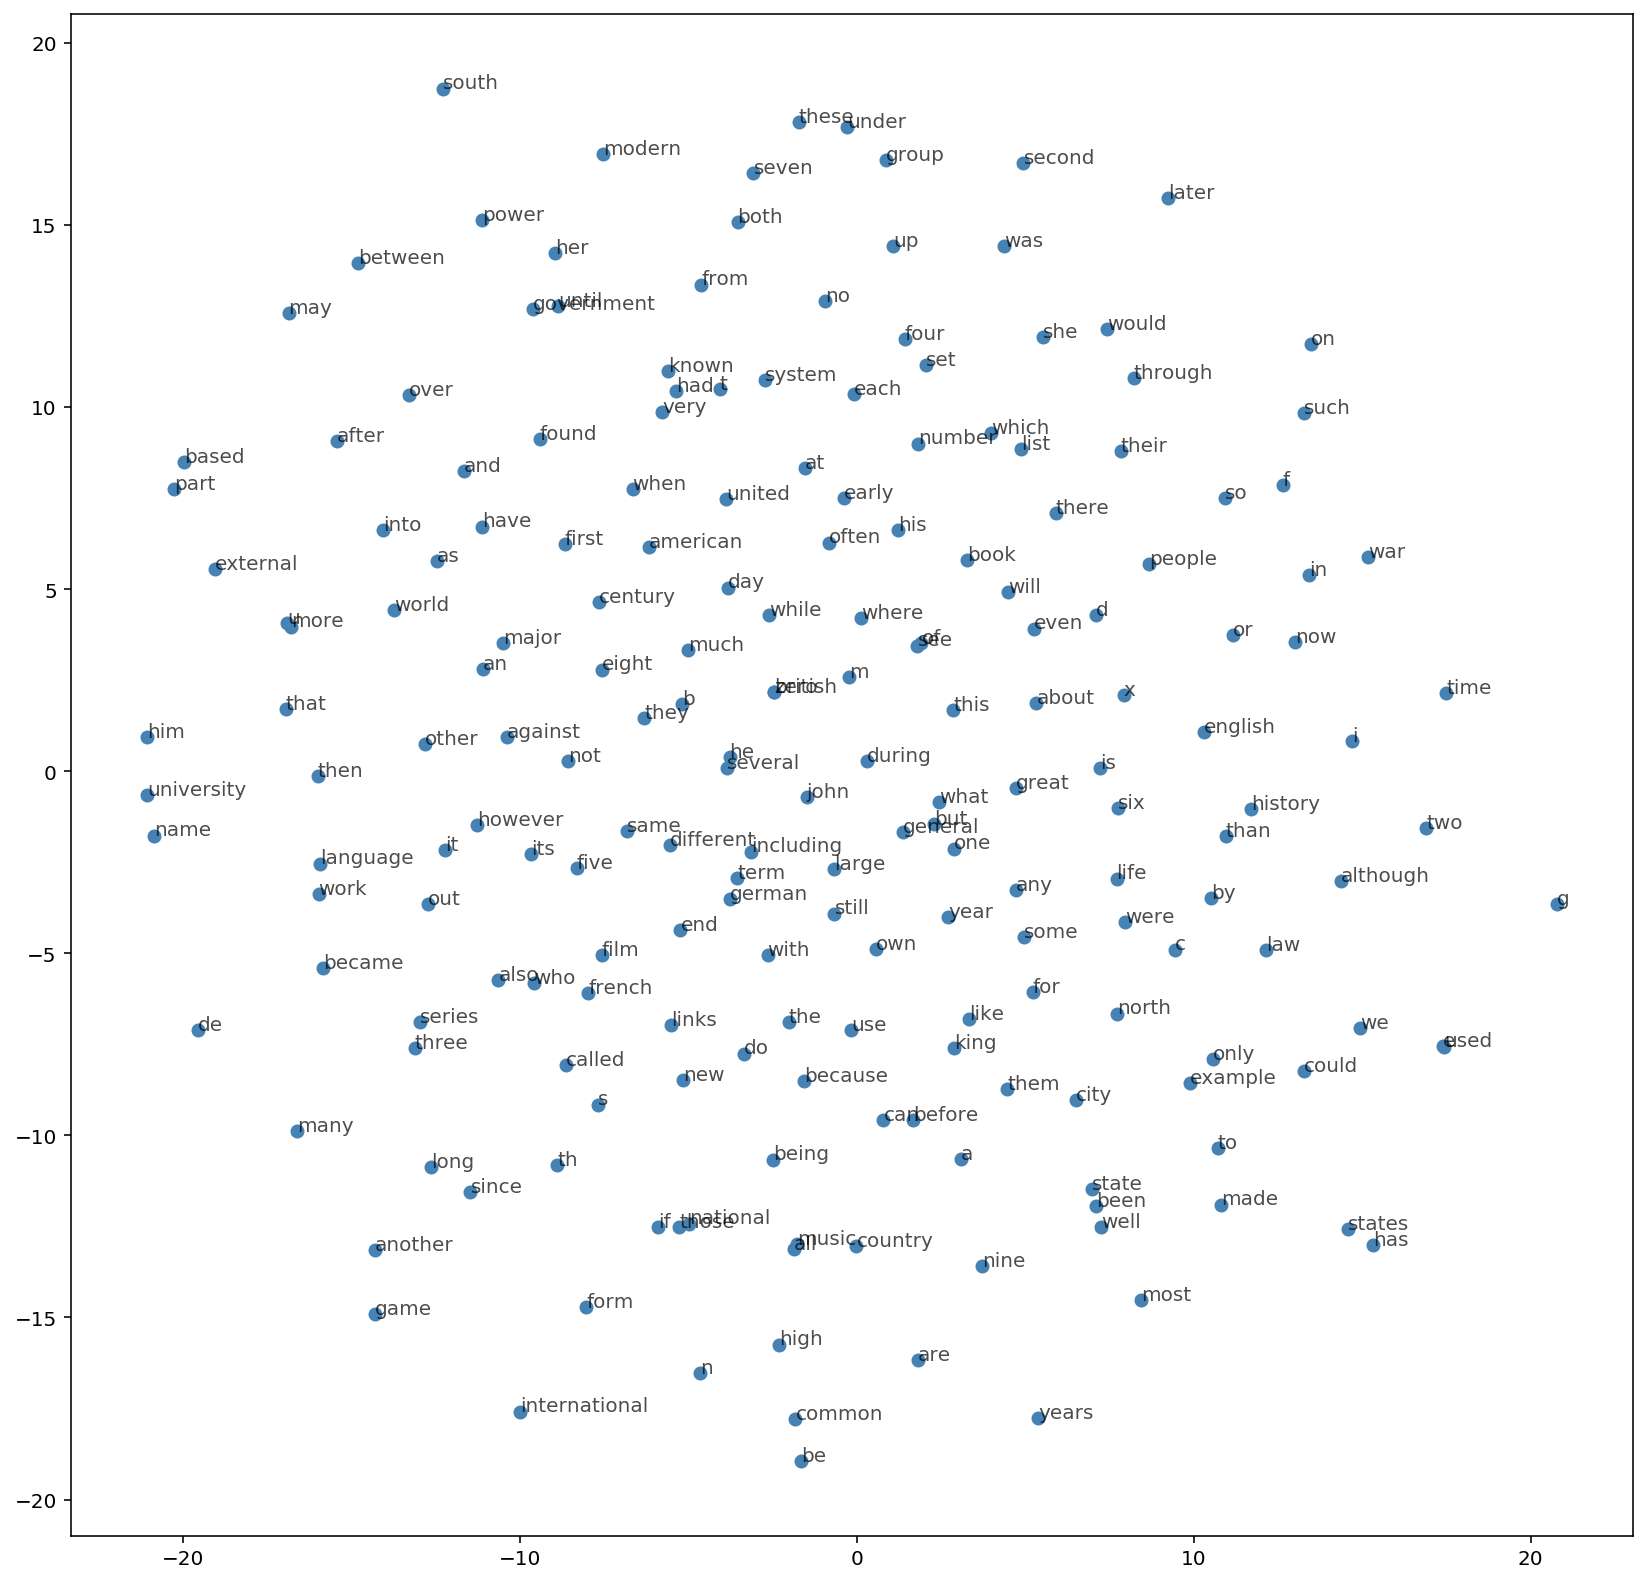

In [118]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(intToWord[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)